# 05c parameter optimisation 

In [1]:
#|default_exp core.05c_parameter_optimisation

In [29]:
#|export
import autograd.numpy as np
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize
from scipy.stats import norm 
import pandas as pd
from matplotlib import pyplot as plt

from dementia_inequalities import const, log, utils, tools 

---

In [3]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [4]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.142036
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.278995
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.129934
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.497021
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.113788


In [5]:
# The real dementia x and y data 

# covariates 
covar = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']

# Input data 
x = np.array(df_dem_plus[covar].values.reshape(-1,7))

# Outcome data 
y = np.array(df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1))

### Optimise the negative log likelihood 

We evaluate the log-likelihood using the maximise function from scikit-learn. This code is written with a little help from my firend ChatGPT - actually it generated the intial code - then I re-wrote 70% of it... 

*Note*: we need the likelihood to be the reflected & shifted log normal - which has an extra parameter (delta) compared to the log normal [see here](https://stats.stackexchange.com/questions/379980/understanding-the-shifted-log-normal-distribution). 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$

The reflected & shifted log-normal PDF at $x$ is: 

$$
p(x|x<\delta, \delta, \mu, \sigma) = 
\frac{1}{(\delta - x)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\delta - x)-\mu)^2}
$$

In the log-normal distribution, 
- $\mu$ is the scale parameter - it stretches and compresses
- $\sigma$ is a shape parameter - it controls how skewed/heavy tailed the distribution is. 
- $\delta$ is the shift parameter - here the shift is the linear equation: $\delta = \beta X$.

Since, we are taking $y_i$ to represent the observed diagnoses, and $\beta X$ to represent the expected a lower bound on the true prevalence rate we have:  

$$
y_i=\beta X_i - \epsilon 
$$ 

Where $\epsilon > 0$. 

We can visualise what the reflected & shifted log normal looks like:




In [6]:
# This is the function to use for plotting 
def reverse_shift_log_normal_pdf(x, delta, mu, sigma):
    pdf = []
    for i, x_i in enumerate(x):
        if delta[i] < x_i: 
            pdf.append(0)
        else: 
            x_shift = delta[i] - x_i
            norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
            exp_part = np.exp(-1 * (1 / (2 * sigma ** 2)) * (np.log(np.subtract(x_shift, mu)) ** 2))
            pdf.append(norm_const.squeeze() * exp_part.squeeze())
            
    return np.array(pdf)

def log_norm_mode(mu:int, # mean of the variables log
                  sigma:int): # standard deviation of the variables log
    return np.exp(mu - sigma**2)

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_84501/489481298.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  norm_const = 1 / ((x_shift) * sigma * np.sqrt(2 * np.pi))
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_84501/489481298.py:11: RuntimeWarning: invalid value encountered in scalar multiply
  pdf.append(norm_const.squeeze() * exp_part.squeeze())


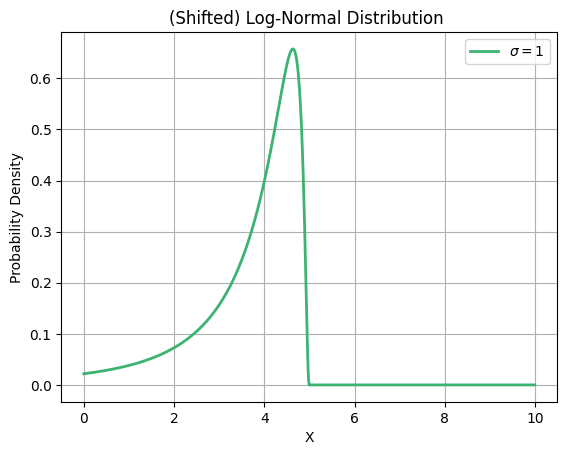

In [7]:
# Parameters for log-normal distribution
mu_0 = 0  # Mean
sigma_0 = 1
shift = 5 # Shift 

x_axis = np.arange(0, 10, 0.01)
shift = shift * np.ones(len(x_axis))

pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, shift, mu_0, sigma_0)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen', label='$\sigma=1$')
#plt.text(6, 0.42, '$\sigma=1$', color='mediumseagreen')
#plt.plot(x, pdf_x_mu1, '-', linewidth=2, color='slateblue', label='$\sigma=0.25$')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

Now, accordingly the probability of a datapoint being distributed according to this log-normal error is: 

$$
p(y_i|y_i < \beta X_i, \beta, \mu, \sigma) = 
\frac{1}{(\beta X_i - y_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X_i - y_i)-\mu)^2}
$$

And hence, the likelihood is: 

$$
L(\delta, \mu, \sigma) = \prod_{i=1}^n s(y_i | y_i < \beta X, \beta X, \mu, \sigma) \\

= \prod_{i=1}^n \frac{1}{(\beta X_i - y_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(\beta X_i - y_i)-\mu)^2}
$$

Let $ z_i = \beta X_i -y_i $. Then we have a log likelihood of:

$$
= \sum_{i=1}^n ln(\frac{1}{z_i \sigma \sqrt{2 \pi}} exp(- \frac{(ln z_i - \mu)^2}{2 \sigma^2})) \\ 
= \sum_{i=1}^n ln(\frac{1}{z_i \sigma \sqrt{2 \pi}} ) - \frac{ln^2z_i -2\mu ln z_i + \mu^2}{2 \sigma^2} \\
= \sum_{i=1}^n - ln(z_i \sigma \sqrt{2 \pi}) - \frac{1}{2 \sigma^2}(ln^2z_i -2\mu ln z_i + \mu^2) \\
= \sum_{i=1}^n \frac{1}{2 \sigma^2}(2\mu ln z_i - ln^2 z_i - \mu^2) - ln(z_i \sigma \sqrt{2 \pi}) \\

$$

In [8]:
# Define functions to minimize

def log_rvs_shift_log_normal(z, delta, mu, sigma):
    pdf = []
    z_shift = np.array(delta - z)
    for i in range(len(z_shift)):
        if z_shift[i]>0: 
            part1 = (1/(2 * sigma ** 2)) * (2 * mu * np.log(z_shift[i]) - (np.log(z_shift[i])) ** 2 - mu ** 2) 
            part2 = np.log(z_shift[i] * sigma * np.sqrt(2 *np.pi))
            pdf.append(part1 - part2)
        else:
            pdf.append(-np.inf) # returns -inf at the points where the log normal is undefined 
    return np.array(pdf)

def neg_loglike(params, x, y):
    beta_0 = params[0]
    beta = np.array(params[1:-2])
    mu = params[-2]
    sigma = params[-1]

    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    log_likely = log_rvs_shift_log_normal(y.squeeze(), delta=y_pred.squeeze(), mu=mu, sigma=sigma)
    
    return (-1 * np.sum(log_likely)).squeeze()

In [9]:
trial_params = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.0, 0.25])
print(neg_loglike(trial_params, x, y))

jacobian_ = jacobian(neg_loglike)

print(jacobian_(trial_params, x, y))

1456.266249108371
[  1768.67745796  44618.02814593 111641.54133364  88739.19989015
 143478.93221752  26369.373887    10600.19537135   3514.11767471
  -3498.67903534  -9820.0940818 ]


## Some slightly unexpected behaviour here 

So, something odd happens here, for certain parameter values the negative log likelihood is positive. This is because the log-normal-pdf can be greater than 1, since it's a continous probability distribution it's only bound in that it's integral =1. As a result, for sharply peaked log normals (when both $\mu$ and $\sigma$ are small) we have $x$ values for which $p(x|\mu, \sigma)$ >1, and hence we end up with $- \sum log(p(x|\mu, \sigma))<0$. 

See this example:

In [10]:
params_practise = [8.755e-01,  1.605e-02, -1.870e-03,  5.155e-04, -3.925e-04, 2.349e-02, -2.511e-02,  1.159e-01, -2.423e-01,  1.215e-01]
print(f'negative log likelihood: {neg_loglike(params_practise, x, y)}')

delta_shift = np.dot(x, params_practise[1:-2]) + 8.755e-01
print(np.prod(reverse_shift_log_normal_pdf(y, delta_shift, -2.423e-01,  1.215e-01)))

negative log likelihood: -286.8638405049893
8.836027987223677e+149


A few checks with simpler examples that the function returns the values we expect

In [11]:
x_practise1 = np.array([[1, 1.5], [2, 3.5]])
y_practise1 = np.array([0, 0])

params_practise1 = np.array([1, 2, 3, 0, 0.5])
# expect neg_loglike = 28.351402187638193
print(neg_loglike(params_practise1, x_practise1, y_practise1))

28.351402187638193


In [12]:
x_practise2 = np.array([[7, 5], [7, 6]])
y_practise2 = np.array([0, 2])

params_practise2 = np.array([0, 0, 2, 1, 0.5])
# expect neg_loglike = 11.84366
print(f'neg loglikelihood: {neg_loglike(params_practise2, x_practise2, y_practise2)}')

jacobian_ = jacobian(neg_loglike)

print(jacobian_(params_practise2, x_practise2, y_practise2))

neg loglikelihood: 11.843664589238777
[  1.24206807   8.69447652   6.83137441 -10.42068074 -23.14764679]


## Using scipy minimize 

Now we use `scipy.minimize` in order to optimise the function. We are using minimize with the negative of the likelihood which should always be positive.

We can initialise from a random point:

In [13]:
# n_features = 7
# np.random.seed(27)
# params_0 = np.concatenate([np.random.normal(size=n_features+1), [0, 0.25]]) 

Or, we initialise from a point near to where we expect the minimum to be (based on the multiple linear regression coefficients):

In [14]:
params_0 = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108, 0.1, 0.25])

There are different methods to optimise, such as Nelder-Mead - which doesn't use the functions derivative.

In [15]:
# Use scipy's minimize function with the Nelder-Mead algorithm
result = minimize(neg_loglike, x0=params_0, args=(x,y), method = 'Nelder-Mead')

result

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -286.86251489336746
             x: [ 8.755e-01  1.605e-02 -1.870e-03  5.155e-04 -3.925e-04
                  2.349e-02 -2.511e-02  1.159e-01 -2.423e-01  1.215e-01]
           nit: 1420
          nfev: 2000
 final_simplex: (array([[ 8.755e-01,  1.605e-02, ..., -2.423e-01,
                         1.215e-01],
                       [ 8.755e-01,  1.605e-02, ..., -2.422e-01,
                         1.214e-01],
                       ...,
                       [ 8.760e-01,  1.605e-02, ..., -2.422e-01,
                         1.214e-01],
                       [ 8.753e-01,  1.605e-02, ..., -2.422e-01,
                         1.215e-01]]), array([-2.869e+02, -2.869e+02, -2.869e+02, -2.869e+02,
                       -2.869e+02, -2.869e+02, -2.869e+02, -2.869e+02,
                       -2.869e+02, -2.869e+02, -2.869e+02]))

Or a method like BFGS which does use the firts derivative:

In [16]:
# derivates of neg_loglike
# jacobian_  = jacobian(neg_loglike)

# result = minimize(neg_loglike, x0=params_0, args=(x,y), method='BFGS', jac = jacobian_, options={'gtol': 1e-6, 'disp':True})
# result

In [17]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:-2]
MLE_mu = MLE_params[-2]
MLE_sigma = MLE_params[-1]

print("MLE estimates \n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')
print("--------------\nLog normal coefficients\n--------------")
print("Mu:", MLE_mu)
print("Sigma:", MLE_sigma)

MLE estimates 
--------------
--------------
Intercept:0.8754936960815751
--------------
Regression coefficients
--------------
over_65_pc:0.016051377777602238
female_pc:-0.0018703213573232971
ALevel_plus_pc:0.0005155078576544667
white_pc:-0.0003924632591874981
HYP_afflicted_pc:0.023487066466692907
DM_afflicted_pc:-0.0251073943370103
STIA_afflicted_pc:0.11587826127816331
--------------
Log normal coefficients
--------------
Mu: -0.24229431336762364
Sigma: 0.12145593662139037


In [18]:
np.array(MLE_params)
neg_loglike(MLE_params, x, y)

-286.86251489336746

In [19]:
print(f'At the MLE, the negative loglikelihood is: {neg_loglike(MLE_params, x, y)}')

At the MLE, the negative loglikelihood is: -286.86251489336746


And we can plot the shape of the log normal

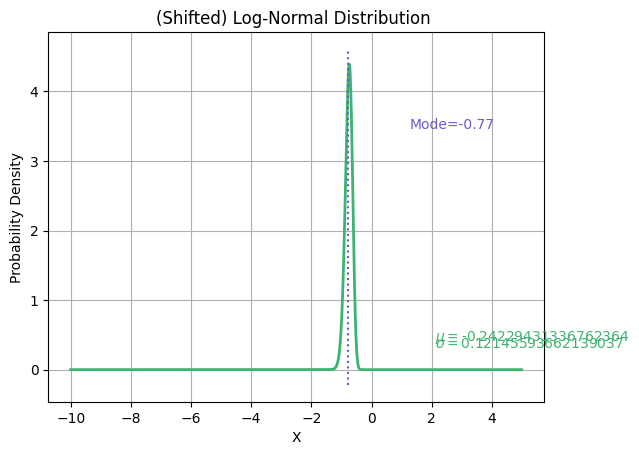

In [20]:
# mode of the log normal 
mode = log_norm_mode(MLE_mu, MLE_sigma)

# plot log normal of MLE parameters 
x_axis = np.arange(-10, 5, 0.01)
pdf_x_mu0 = reverse_shift_log_normal_pdf(x_axis, np.zeros(len(x_axis)), MLE_mu, MLE_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x_axis, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen')
plt.text(2.1, 0.32, f'$\sigma=${MLE_sigma}', color='mediumseagreen')
plt.text(2.1, 0.42, f'$\mu=${MLE_mu}', color='mediumseagreen')
#plt.text(7, 0.15, '$\sigma=0.25$', color='slateblue')

ymin, ymax = plt.ylim()
plt.vlines(-mode, ymin, ymax, color='slateblue', label='Log normal mode', linestyles='dotted')
plt.text(mode+0.5, 3*ymax/4, f'Mode={np.round(-mode,2)}', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [21]:
# The values predicted by the linear regression - conceptually this should be the "true" dementia prevalence rates 
y_pred = np.dot(x, MLE_beta.T) + MLE_intercept
diagnosis_gap = y_pred.squeeze() - y.squeeze()

# update the dataframe 
df_dem_plus['diagnosis_gap']=diagnosis_gap

In [22]:
print(y_pred[:5])

[1.93572067 1.3922385  1.56264692 1.57327131 1.69777283]


And subsquently look at those regions with the largest gap from the regression line - conceptually those with the worst diagnosis rates

In [23]:
most_bad_lads = np.argsort(diagnosis_gap)[-10:]
df_dem_plus.iloc[most_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
107,Cornwall,0.957613
60,Worcester,0.957710
286,Torridge,0.962688
294,Nuneaton and Bedworth,0.963476
75,Redditch,0.968367
134,Scarborough,0.971210
79,Wychavon,0.972815
283,City of London,1.017861
40,South Hams,1.043275
271,Eden,1.045234


And those regions with the smallest gap - conceptually those with the best diagnosis rates

In [24]:
least_bad_lads = np.argsort(diagnosis_gap)[:10]
df_dem_plus.iloc[least_bad_lads, :][['area_name', 'diagnosis_gap']]

,area_name,diagnosis_gap
77,Rochford,0.449314
225,Southampton,0.542680
123,Surrey Heath,0.544964
29,East Devon,0.547082
196,East Hampshire,0.553213
63,Eastbourne,0.554127
10,Southend-on-Sea,0.565579
3,Lancaster,0.576326
138,Ashfield,0.579683
272,Gosport,0.593679


## Evaluate the hessian at the MLE 

We can look at the Hessian evaluated at the MLE.

In [25]:
hessian_ = hessian(neg_loglike)

print(hessian_(MLE_params, x, y))

[[ 3.57219540e+04  8.70029651e+05  2.24893226e+06  1.81088517e+06
   2.80586847e+06  5.20097021e+05  2.11822376e+05  6.87547205e+04
  -2.68885837e+04  6.79800828e+03]
 [ 8.70029651e+05  2.23158274e+07  5.46830316e+07  4.35465824e+07
   7.13226865e+07  1.30956472e+07  5.22179751e+06  1.76045452e+06
  -6.54351877e+05  1.59384262e+05]
 [ 2.24893226e+06  5.46830316e+07  1.41929459e+08  1.14085126e+08
   1.76077849e+08  3.27093951e+07  1.33502503e+07  4.31364996e+06
  -1.69314303e+06  4.28848630e+05]
 [ 1.81088517e+06  4.35465824e+07  1.14085126e+08  9.38760050e+07
   1.40173668e+08  2.59557848e+07  1.05484575e+07  3.42168161e+06
  -1.36557855e+06  3.31882368e+05]
 [ 2.80586847e+06  7.13226865e+07  1.76077849e+08  1.40173668e+08
   2.32372465e+08  4.20456103e+07  1.67318915e+07  5.65541897e+06
  -2.10901084e+06  5.25317243e+05]
 [ 5.20097021e+05  1.30956472e+07  3.27093951e+07  2.59557848e+07
   4.20456103e+07  7.78287090e+06  3.13451513e+06  1.03800358e+06
  -3.91252147e+05  9.69501873e+04

In [26]:
def is_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [27]:
np.linalg.eigvals(hessian_(MLE_params, x, y))

array([4.89370200e+08, 8.88172829e+06, 1.09008049e+06, 3.77676207e+05,
       4.16249448e+04, 3.52120371e+04, 5.91835503e+03, 2.10459534e+01,
       7.78215987e+01, 8.30632875e+02])

In [28]:
is_def(hessian_(MLE_params, x, y))

True

## Check the model by just looking at the linear regression with a gaussian error term 

In [46]:
# Define functions to minimize

def linear_neg_loglike(params, x, y):
    beta_0 = params[0]
    beta = np.array(params[1:-1])
    sigma = params[-1]

    y_pred = (np.dot(x, beta)).squeeze() + beta_0
    likely = norm.pdf(y, loc=y_pred, scale=sigma)
    log_likely = np.log(likely)
    #log_likely = log_rvs_shift_log_normal(y.squeeze(), delta=y_pred.squeeze(), mu=mu, sigma=sigma)
    
    return (-1 * np.sum(log_likely)).squeeze()

In [71]:
# Define functions to minimize

def linear_log_ols(params, x, y):
    beta_0 = params[0]
    beta = np.array(params[1:])

    y_pred = (np.dot(x, beta)).squeeze() + beta_0

    squares = (y_pred-y)**2
    
    return (np.sum(squares)).squeeze()

In [72]:
# initial values 
params_0 = np.array([0.25, 0.1, 0.004, -0.004, -0.003, 0.0157, -0.0138, 0.108])

# Use scipy's minimize function with the Nelder-Mead algorithm
result = minimize(linear_log_ols, x0=params_0, args=(x,y), method = 'Nelder-Mead')

result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3891.3000680477276
             x: [ 2.730e-01  1.908e-03  9.658e-03 -1.089e-03 -1.719e-03
                  9.424e-04 -1.214e-02  4.694e-02]
           nit: 938
          nfev: 1385
 final_simplex: (array([[ 2.730e-01,  1.908e-03, ..., -1.214e-02,
                         4.694e-02],
                       [ 2.730e-01,  1.907e-03, ..., -1.214e-02,
                         4.692e-02],
                       ...,
                       [ 2.731e-01,  1.908e-03, ..., -1.214e-02,
                         4.692e-02],
                       [ 2.730e-01,  1.907e-03, ..., -1.214e-02,
                         4.693e-02]]), array([ 3.891e+03,  3.891e+03,  3.891e+03,  3.891e+03,
                        3.891e+03,  3.891e+03,  3.891e+03,  3.891e+03,
                        3.891e+03]))

In [73]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:]
MLE_sigma = MLE_params[-1]

print("MLE estimates \n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')

MLE estimates 
--------------
--------------
Intercept:0.27301426690385544
--------------
Regression coefficients
--------------
over_65_pc:0.0019075626721195226
female_pc:0.009658495462896887
ALevel_plus_pc:-0.00108882425238399
white_pc:-0.0017193052095990575
HYP_afflicted_pc:0.0009423790372619506
DM_afflicted_pc:-0.012140858915620684
STIA_afflicted_pc:0.046937148357669156


In [74]:
try_these_params = [0.11672, 1.67110984e-02, -1.77265952e-03,  1.65726780e-04,  8.33134840e-05,
        1.80178425e-02, -1.36733891e-02,  9.05360780e-02, 0.1]

linear_neg_loglike(try_these_params, x, y)

205377.60791360313

In [75]:
# Extract the MLE from the parameter samples
MLE_params = result.x

MLE_intercept = MLE_params[0]
MLE_beta = MLE_params[1:-1]
MLE_sigma = MLE_params[-1]

print("MLE estimates \n--------------\n--------------")
print(f'Intercept:{MLE_intercept}')
print("--------------\nRegression coefficients\n--------------")
for i, var in enumerate(covar):
    print(f'{var}:{MLE_beta[i]}')
print("--------------\nLog normal coefficients\n--------------")
print("Sigma:", MLE_sigma)

MLE estimates 
--------------
--------------
Intercept:0.27301426690385544
--------------
Regression coefficients
--------------
over_65_pc:0.0019075626721195226
female_pc:0.009658495462896887
ALevel_plus_pc:-0.00108882425238399
white_pc:-0.0017193052095990575
HYP_afflicted_pc:0.0009423790372619506
DM_afflicted_pc:-0.012140858915620684


IndexError: index 6 is out of bounds for axis 0 with size 6